In [13]:
from PaperTennis_env import PaperTennisEnv
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os.path
from os import path
import scipy.io

In [2]:
#Hyperparms
GAMMA = 0.9
ALPHA = 0.1
E_GREEDY = 0.1

Startegies = {
    "Mean": 1,
    "Long": 2,
    "Short": 3,
    "Rand": 4,
}

In [14]:
# Run Parms !!!!!
OPP_Strat='Rand'
Reset = False
NUM_EPISODES = 1000000

# Get Opponent Startegy index
OPPONENT = Startegies[OPP_Strat]

# Init or load value method
if Reset or not(path.exists(OPP_Strat + '.p')):
    print('New Q Values Initialized...')
    Q_val = np.zeros([5,51,51,50])
    train_episodes = 0;
else:
    train_episodes, Q_val = pickle.load(open(OPP_Strat + '.p', "rb" ) )

New Q Values Initialized...


In [4]:
# Get action e-greedy
def get_action(state,Q_val):
    if state[1] == 0:
        return 0

    p_epsilon = np.random.uniform(0,1)
    if p_epsilon < E_GREEDY:
        return np.argmax(np.random.uniform(0,1,(1,state[1]))) + 1

    q_s = np.zeros(state[1])

    for i in range(1,state[1]):
        q_s[i] = Q_val[state[0],state[1],state[2],i]

    return np.argmax(q_s) + 1

In [17]:
start_time = time.time()

# init env
env = PaperTennisEnv()

# Plotting Stuff
trend_wins = np.zeros(NUM_EPISODES-100)
trend_TD = np.zeros(NUM_EPISODES-100)
cum_reward = np.zeros(NUM_EPISODES+1)

wins = np.zeros(NUM_EPISODES)
td_error = np.zeros(NUM_EPISODES)

for episode in range(NUM_EPISODES):

    env.reset()
    state = env.state
    done = False

    action = get_action(state,Q_val)

    # Generate an episode
    error_episode = 0
    while not done:

        state_prime, reward, done = env.step(action,OPPONENT)

        action_prime = get_action(state_prime,Q_val)

        # SARSA tabular update (Section 6.5 S.B., psuedocode)
        TD_error = (reward + GAMMA * Q_val[state_prime[0],state_prime[1],state_prime[2],action_prime-1]
            -Q_val[state[0],state[1],state[2],action-1])

        Q_val[state[0],state[1],state[2],action-1] = Q_val[state[0],state[1],state[2],action-1] + ALPHA*TD_error

        error_episode += abs(TD_error)

        state  = state_prime
        action = action_prime

        if (done and reward == 1):
            wins[episode] = 1
            

    td_error[episode] = error_episode
    if episode >= 100:
        trend_wins[episode-100] = np.sum(wins[episode-100:episode])
        trend_TD[episode-100] = np.sum(td_error[episode-100:episode])
    
    if episode%10000 == 0: print("Episode %d completed with reward %d" % (episode, reward))

# Update total episode count
train_episodes += episode +1 
        
# Save Q-val Table and episode count
pickle.dump([train_episodes,Q_val], open(OPP_Strat + '.p', "wb" ) )

# Print run details
print("--- %s seconds ---" % (time.time() - start_time))
print("Final mean win percent = %s " % (np.mean(trend_wins[-10000:])))
print("Zero Q-Vals = %s " % (np.count_nonzero(Q_val==0)))
print("Total Episodes %s " % (train_episodes))

Episode 0 completed with reward 1
Episode 10000 completed with reward 1
Episode 20000 completed with reward 1
Episode 30000 completed with reward 1
Episode 40000 completed with reward -1
Episode 50000 completed with reward 1
Episode 60000 completed with reward 1
Episode 70000 completed with reward 1
Episode 80000 completed with reward -1
Episode 90000 completed with reward 1
Episode 100000 completed with reward 1
Episode 110000 completed with reward 1
Episode 120000 completed with reward 1
Episode 130000 completed with reward 1
Episode 140000 completed with reward 1
Episode 150000 completed with reward 1
Episode 160000 completed with reward 1
Episode 170000 completed with reward 1
Episode 180000 completed with reward 1
Episode 190000 completed with reward 1
Episode 200000 completed with reward 1
Episode 210000 completed with reward 1
Episode 220000 completed with reward -1
Episode 230000 completed with reward -1
Episode 240000 completed with reward 1
Episode 250000 completed with rewar

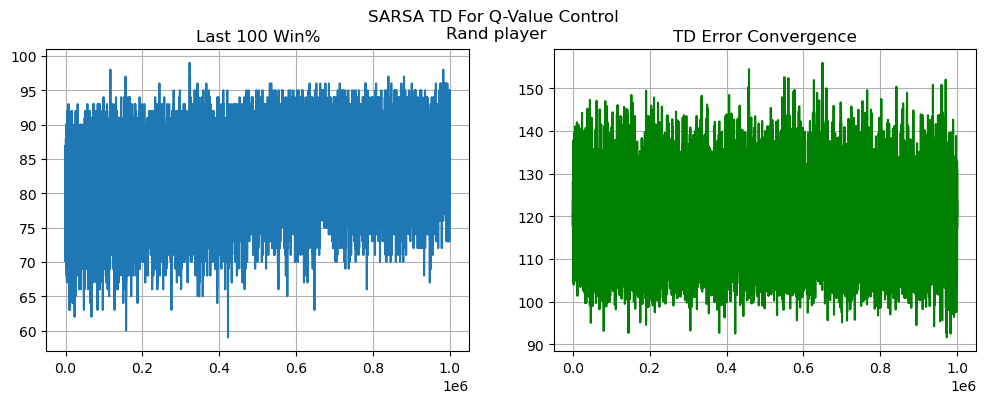

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k')
ax1.plot(range(100,NUM_EPISODES),trend_wins)
ax2.plot(range(100,NUM_EPISODES),trend_TD,c='g')
ax1.title.set_text("Last 100 Win%")
ax2.title.set_text("TD Error Convergence")
fig.suptitle('SARSA TD For Q-Value Control \n' +  OPP_Strat + ' player')
# ax1.set_xscale('log')
# ax2.set_xscale('log')
ax1.grid()
ax2.grid()

In [22]:
# Matlab export

scipy.io.savemat('StrategySim/'+ OPP_Strat + '.mat', mdict={'Q_val': Q_val})